In [1]:
%matplotlib inline  

In [2]:
import os
import sys
import math
import numpy as np
import math
import torch
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.utils.data as data_utils

from pathlib import Path

In [3]:
os.chdir("..")

In [4]:
from optbnn.gp.models.gpr import GPR
from optbnn.gp import kernels, mean_functions, priors
from optbnn.bnn.reparam_nets import GaussianMLPReparameterization
from optbnn.bnn.nets.mlp import MLP
from optbnn.bnn.likelihoods import LikCategorical
from optbnn.bnn.priors import OptimGaussianPrior, FixedGaussianPrior
from optbnn.prior_mappers.wasserstein_mapper import MapperWasserstein, WassersteinDistance
from optbnn.utils.rand_generators import ClassificationGenerator
from optbnn.utils.normalization import normalize_data
from optbnn.utils import util
from optbnn.sgmcmc_bayes_net.classification_net import ClassificationNet

In [5]:
mpl.rcParams['figure.dpi'] = 100

In [6]:
util.set_seed(123)

# 1. Load `Banana` dataset

In [7]:
DATA_DIR = "./data/banana"
OUT_DIR = "./exp/banana"

In [8]:
# Load banana dataset
X = np.loadtxt(os.path.join(
    DATA_DIR, "banana_X_train"), delimiter=",").astype(np.float32)
y = np.loadtxt(os.path.join(
    DATA_DIR, "banana_Y_train"), delimiter=",").reshape([-1]).astype(np.int64)

In [9]:
# Setup directories
ckpt_dir = os.path.join(OUT_DIR, "ckpts")
figs_dir = os.path.join(OUT_DIR, "figs")
util.ensure_dir(ckpt_dir)
util.ensure_dir(figs_dir)

# 2. Configure hyper-parameters

Configure the neural network architecture. In this experiment, we use a 2-hidden layer MLP with tanh activation function. The number of hidden units at each layer is 100.

In [10]:
input_dim = 2
output_dim = 2
hidden_dims = [100] * 2
activation_fn = "tanh"

Configure the hyper-parameters ofWasserstein optimization.  

In [11]:
mapper_batch_size = 256        # The size of the measurement set. The measurement points are sampled from the training data.
mapper_n_samples = 128         # The size of mini batch used in Wasserstein optimization
mapper_n_lipschitz_iters = 200 # The number of Lipschitz function iterations per prior iteration
mapper_n_prior_iters = 200     # The number of prior iterations
mapper_lipschitz_lr = 0.02     # The learning rate for the opimization of the Lipschitz function (inner loop)
mapper_prior_lr = 0.05         # The learning rate for the optimization of the prior (outer loop)

Configure the hyper-parameters for the SGHMC sampler.  

In [12]:
sampler_batch_size = 32
sampling_configs = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

# 3. Optimize priors

In [12]:
input_dim = 2

# Initialize data loader for the mapper
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X),
                                             torch.from_numpy(y)),
                    batch_size=mapper_batch_size, shuffle=True)

# Setup the measurement set generator
# We draw measurement points from the training data
rand_generator = ClassificationGenerator(data_loader)

# Specify the target GP prior
lengthscale = math.sqrt(2. * input_dim)
variance = 8.

X_, y_ = rand_generator.get(return_label=True)
kernel = kernels.RBF(
    input_dim,
    lengthscales=torch.tensor([lengthscale], dtype=torch.double),
    variance=torch.tensor([variance], dtype=torch.double),
    ARD=True)

kernel.lengthscales.prior = priors.LogNormal(
        torch.ones([input_dim]) * math.log(lengthscale),
        torch.ones([input_dim]) * 1.)

kernel.variance.prior = priors.LogNormal(
    torch.ones([1]) * math.log(variance),
    torch.ones([1]) * 0.3)

gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                    util.to_one_hot(y_).double(),
                    kern=kernel, mean_function=mean_functions.Zero())

# Initialize the Gaussian prior to optimize
mlp_reparam = GaussianMLPReparameterization(input_dim, output_dim,
    hidden_dims, activation_fn, scaled_variance=True)

# Initialize the mapper
saved_dir = os.path.join(OUT_DIR, "hierarchical")
mapper = MapperWasserstein(gp, mlp_reparam, rand_generator, out_dir=saved_dir,
                           output_dim=output_dim,
                           n_data=mapper_batch_size,
                           wasserstein_steps=(0, mapper_n_lipschitz_iters),
                           wasserstein_lr=mapper_lipschitz_lr,
                           wasserstein_thres=0.1,
                           n_gpu=1)

# Start optimization
print("Start optimizing prior")
w_hist = mapper.optimize(num_iters=mapper_n_prior_iters, n_samples=mapper_n_samples,
                lr=mapper_prior_lr, print_every=5,
                save_ckpt_every=20, debug=True)
path = os.path.join(saved_dir, "wsr_values.log")
np.savetxt(path, w_hist, fmt='%.6e')
print("----" * 20)

Start optimizing prior
>>> Iteration #   1: Wasserstein Dist 125.7416
>>> Iteration #   5: Wasserstein Dist 8.4161
>>> Iteration #  10: Wasserstein Dist 14.2983
>>> Iteration #  15: Wasserstein Dist 10.7402
>>> Iteration #  20: Wasserstein Dist 11.4510
>>> Iteration #  25: Wasserstein Dist 5.8024
>>> Iteration #  30: Wasserstein Dist 4.8648
>>> Iteration #  35: Wasserstein Dist 9.0572
>>> Iteration #  40: Wasserstein Dist 2.7597
>>> Iteration #  45: Wasserstein Dist 7.2504
>>> Iteration #  50: Wasserstein Dist 5.5330
>>> Iteration #  55: Wasserstein Dist 16.0414
>>> Iteration #  60: Wasserstein Dist 2.7875
>>> Iteration #  65: Wasserstein Dist 1.6808
>>> Iteration #  70: Wasserstein Dist 3.8779
>>> Iteration #  75: Wasserstein Dist -0.8842
>>> Iteration #  80: Wasserstein Dist 7.4204
>>> Iteration #  85: Wasserstein Dist 8.7739
>>> Iteration #  90: Wasserstein Dist 4.1306
>>> Iteration #  95: Wasserstein Dist 0.2905
>>> Iteration # 100: Wasserstein Dist -2.3849
>>> Iteration # 105: Was

## 3.1 Visualize the convergence plots

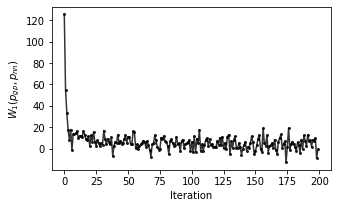

In [17]:
fig = plt.figure(figsize=(5, 3))

wdist_file = os.path.join(OUT_DIR, "hierarchical", "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

plt.plot(wdist_vals, "-ok", ms=2, alpha=0.8)
plt.xlabel("Iteration")
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.show()

# 4. Sample from posterior using SGHMC sampler

In [20]:
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
# Setup the likelihood
net = MLP(input_dim, output_dim, hidden_dims, activation_fn,
        task="classification")
likelihood = LikCategorical()

# Load the optimized prior
saved_dir = os.path.join(OUT_DIR, "hierarchical")
ckpt_path = os.path.join(saved_dir, "ckpts", "it-{}.ckpt".format(mapper_n_prior_iters))
print("Loading prior: {}".format(ckpt_path))
prior = OptimGaussianPrior(ckpt_path)

# Initialize the Bayesian net
samples_dir = os.path.join(saved_dir, "samples")
util.ensure_dir(samples_dir)
bayes_net = ClassificationNet(net, likelihood, prior, saved_dir, n_gpu=0)

# Start sampling using SGHMC sampler
bayes_net.sample_multi_chains(data_loader=data_loader, **sampling_configs)
mean_preds, preds = bayes_net.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = bayes_net.predict(
            data, return_individual_predictions=True,
            num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = bayes_net.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()

# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(saved_dir, "preds.pickle"), 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

Loading prior: ./exp/banana/hierarchical/ckpts/it-200.ckpt
Chain: 0
Samples #     5 : NLL = 0.10592 Acc = 1.0000 
Samples #    10 : NLL = 0.12501 Acc = 0.9688 
Samples #    15 : NLL = 0.18596 Acc = 0.9375 
Samples #    20 : NLL = 0.08872 Acc = 1.0000 
Samples #    25 : NLL = 0.18447 Acc = 0.9688 
Samples #    30 : NLL = 0.26645 Acc = 0.8750 
Chain: 1
Samples #    35 : NLL = 0.31364 Acc = 0.8125 
Samples #    40 : NLL = 0.25271 Acc = 0.8750 
Samples #    45 : NLL = 0.19041 Acc = 0.9375 
Samples #    50 : NLL = 0.09256 Acc = 1.0000 
Samples #    55 : NLL = 0.23789 Acc = 0.8750 
Samples #    60 : NLL = 0.24201 Acc = 0.9375 
Chain: 2
Samples #    65 : NLL = 0.28993 Acc = 0.8438 
Samples #    70 : NLL = 0.30030 Acc = 0.8438 
Samples #    75 : NLL = 0.18345 Acc = 0.9062 
Samples #    80 : NLL = 0.22084 Acc = 0.9375 
Samples #    85 : NLL = 0.19067 Acc = 0.9688 
Samples #    90 : NLL = 0.22572 Acc = 0.9062 
Chain: 3
Samples #    95 : NLL = 0.15694 Acc = 0.9688 
Samples #   100 : NLL = 0.21776

120it [00:00, 147.27it/s]


# 5. Visualize predictive posterior

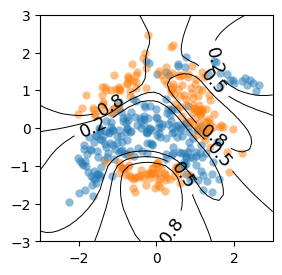

In [33]:
fig = plt.figure(figsize=(3, 3))

data_file = os.path.join(OUT_DIR, "hierarchical", "preds.pickle")
        
with open(data_file, "rb") as f:
    data = pickle.load(f)

X = data['X']
y = data['y']
p = data['p']
xx = data['xx']
yy = data['yy']

mask = y.reshape([-1, 1])[:, 0] == 1
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

plt.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
CS = plt.contour(
    xx,
    yy,
    p[:, 0].reshape(*xx.shape),
    [0.2, 0.5, 0.8],
    colors="k",
    linewidths=0.7,
    zorder=100,
)
plt.clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
plt.show()